In [1]:
from imblearn.over_sampling import SMOTE,ADASYN
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [0]:
import keras
keras.backend.clear_session()
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
os.chdir('/content/drive/My Drive/PCB/Train_Data')
train_x = np.load('train_X.npy')
train_x = train_x[1:10000,100:200,100:200,:];
train_y = np.load('train_y.npy')
train_y = train_y[1:10000]

In [0]:
print(train_y)

[0. 0. 0. ... 0. 0. 0.]


In [0]:
num_classes = 2
print(np.unique(train_y,return_counts=True))
train_y= np_utils.to_categorical(train_y, num_classes)

(array([0.]), array([9999]))


In [0]:
print(len(train_x))
print(len(train_y))
print(train_x.shape)
print(train_y.shape)

9999
9999
(9999, 100, 100, 3)
(9999, 2)


In [0]:
print(train_y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
mean = np.mean(train_x)
std = np.std(train_x)
print (mean, std)

train_x = train_x - mean
train_x = train_x / std
print(train_x.shape)
print(train_y.shape)

69.2022531486482 60.98429473106062
(9999, 100, 100, 3)
(9999, 2)


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=2)

print(len(X_train))
print(len(y_train))

print("")

print(len(X_valid))
print(len(y_valid))

print("")

print(X_train.shape)
print(y_train.shape)

print("")

print(X_valid.shape)
print(y_valid.shape)

7999
7999

2000
2000

(7999, 100, 100, 3)
(7999, 2)

(2000, 100, 100, 3)
(2000, 2)


In [0]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
#y_train = np.reshape(y_train,(-1,1))

X_valid = X_valid.astype('float32')
y_valid = y_valid.astype('float32')
#y_valid = np.reshape(y_valid,(-1,1))


print(X_train.shape)
print(y_train.shape)
print("")
print(X_valid.shape)
print(y_valid.shape)

(7999, 100, 100, 3)
(7999, 2)

(2000, 100, 100, 3)
(2000, 2)


In [0]:
from keras import layers
from keras.models import Model

def _after_conv(in_tensor):
    norm = layers.BatchNormalization()(in_tensor)
    return layers.Activation('relu')(norm)

def conv1(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=1)(in_tensor)
    return _after_conv(conv)

def conv1_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=2)(in_tensor)
    return _after_conv(conv)

def conv3(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(in_tensor)
    return _after_conv(conv)

def conv3_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(in_tensor)
    return _after_conv(conv)

def resnet_block_wo_bottlneck(in_tensor, filters, downsample=False):
    if downsample:
        conv1_rb = conv3_downsample(in_tensor, filters)
    else:
        conv1_rb = conv3(in_tensor, filters)
    conv2_rb = conv3(conv1_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    result = layers.Add()([conv2_rb, in_tensor])

    return layers.Activation('relu')(result)

def resnet_block_w_bottlneck(in_tensor,
                             filters,
                             downsample=False,
                             change_channels=False):
    if downsample:
        conv1_rb = conv1_downsample(in_tensor, int(filters/4))
    else:
        conv1_rb = conv1(in_tensor, int(filters/4))
    conv2_rb = conv3(conv1_rb, int(filters/4))
    conv3_rb = conv1(conv2_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    elif change_channels:
        in_tensor = conv1(in_tensor, filters)
    result = layers.Add()([conv3_rb, in_tensor])

    return result

def _pre_res_blocks(in_tensor):
    conv = layers.Conv2D(64, 7, strides=2, padding='same')(in_tensor)
    conv = _after_conv(conv)
    pool = layers.MaxPool2D(3, 2, padding='same')(conv)
    return pool

def _post_res_blocks(in_tensor, n_classes):
    pool = layers.GlobalAvgPool2D()(in_tensor)
    preds = layers.Dense(n_classes, activation='softmax')(pool)
    return preds

def convx_wo_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_wo_bottlneck(res, filters, downsample_1)
        else:
            res = resnet_block_wo_bottlneck(res, filters)
    return res

def convx_w_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_w_bottlneck(res, filters, downsample_1, not downsample_1)
        else:
            res = resnet_block_w_bottlneck(res, filters)
    return res

def _resnet(in_shape=(224,224,3),
            n_classes=1000,
            convx=[64, 128, 256, 512],
            n_convx=[2, 2, 2, 2],
            convx_fn=convx_wo_bottleneck):
    in_layer = layers.Input(in_shape)

    downsampled = _pre_res_blocks(in_layer)

    conv2x = convx_fn(downsampled, convx[0], n_convx[0])
    conv3x = convx_fn(conv2x, convx[1], n_convx[1], True)
    conv4x = convx_fn(conv3x, convx[2], n_convx[2], True)
    conv5x = convx_fn(conv4x, convx[3], n_convx[3], True)

    preds = _post_res_blocks(conv5x, n_classes)

    model = Model(in_layer, preds)
    return model

def resnet18(in_shape=(100,100,3), n_classes=2):
    return _resnet(in_shape, n_classes)

def resnet34(in_shape=(100,100,3), n_classes=2):
    return _resnet(in_shape,n_classes,n_convx=[3, 4, 6, 3])

def resnet50(in_shape=(100,100,3), n_classes=2):
    return _resnet(in_shape,n_classes,[256, 512, 1024, 2048],[3, 4, 6, 3],convx_w_bottleneck)

def resnet101(in_shape=(300,300,3), n_classes=2):
    return _resnet(in_shape,n_classes,[256, 512, 1024, 2048],[3, 4, 23, 3],convx_w_bottleneck)

def resnet152(in_shape=(300,300,3), n_classes=2):
    return _resnet(in_shape,n_classes,[256, 512, 1024, 2048],[3, 8, 36, 3],convx_w_bottleneck)

if __name__ == '__main__':
    model = resnet50()
    print(model.summary())









Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 50, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________

In [0]:
# os.chdir('/home/student/Documents/PCB_3/Models/Res50/Results')
# from keras.callbacks import ModelCheckpoint,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
# mc = ModelCheckpoint('PCB3_Res50_Aug_data_100*100.h5', monitor='val_loss', mode='min',save_best_only=True)
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
# cv = CSVLogger('PCB3_Res50_Aug_data_100*100.csv',append=True)
# tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

In [0]:
import keras
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
# X_valid = X_valid.reshape(60000,-1 )
# #y_valid = y_valid.reshape(12000, -1)

# X_valid, y_valid = SMOTE().fit_resample(X_valid, y_valid)
# # X_train, y_train = SMOTE().fit_resample(X_train, y_train)


In [0]:
batch_size = 32
epochs = 200
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_valid,y_valid),verbose = 1,shuffle=True)    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7999 samples, validate on 2000 samples
Epoch 1/200
7999/7999 [==============================] - 307s 38ms/step - loss: 0.0168 - acc: 0.9987 - val_loss: 1.1966e-07 - val_acc: 1.0000
Epoch 2/200
 960/7999 [==>...........................] - ETA: 4:01 - loss: 1.5808e-07 - acc: 1.0000

In [0]:
os.chdir('/content/drive/My Drive/PCB/Test_Data')

unseen_d = np.load('test_X.npy')
unseen_l = np.load('test_y.npy')

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(unseen_d, unseen_l, test_size=0.2, shuffle= True)

print(unseen_d.shape)
print(unseen_l.shape)

(2838, 300, 300, 3)
(2838,)


In [0]:
unseen_d=unseen_d[:,100:200,100:200,:];
print(unseen_d.shape)

(2838, 100, 100, 3)


In [0]:
print(len(unseen_d))
print(len(unseen_l))
print(unseen_d.shape)
print(unseen_l.shape)

2838
2838
(2838, 100, 100, 3)
(2838,)


In [0]:
unseen_d = unseen_d.reshape(unseen_d.shape[0],100,100,3).astype('float32')
mean=62.34
std=58.20
 
unseen_d = unseen_d - mean
unseen_d = unseen_d / std
print (unseen_d.shape)
unseen_d = unseen_d.astype('float32')
unseen_l = unseen_l.astype('float32')

(2838, 100, 100, 3)


In [0]:
num_classes = 2
print(np.unique(unseen_l,return_counts=True))
unseen_l= np_utils.to_categorical(unseen_l, num_classes)
print(unseen_l.shape)

(array([0., 1.], dtype=float32), array([  75, 2763]))
(2838, 2)


In [0]:
model.evaluate(unseen_d,unseen_l)

2838/2838 [==============================] - 2s 821us/step


[2.075784620220515, 0.0380549682980276]

In [0]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, precision_score
import itertools

Y_pred = model.predict(unseen_d)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Deffect 0', 'Non deffect 1']
print(classification_report(np.argmax(unseen_l,axis=1), y_pred,target_names=target_names))



               precision    recall  f1-score   support

    Deffect 0       0.03      0.99      0.05        75
Non deffect 1       0.97      0.01      0.02      2763

     accuracy                           0.04      2838
    macro avg       0.50      0.50      0.04      2838
 weighted avg       0.95      0.04      0.03      2838



In [0]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i+0.25 if i==0 else i-0.25, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  74    1]
 [2729   34]]
0.03805496828752643
0.9619450317124736


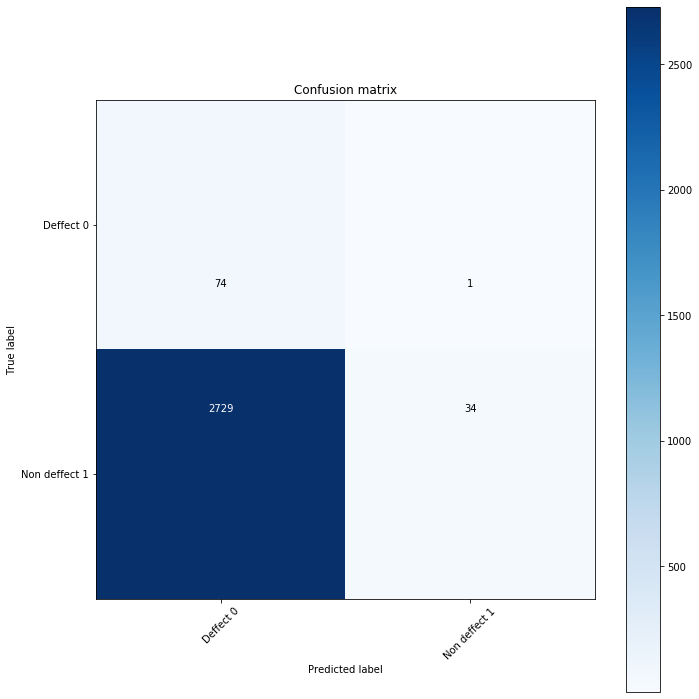

In [0]:
cnf_matrix = (confusion_matrix(np.argmax(unseen_l,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')